## Define Module

In [2]:
import os
import sys
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal

## Define Class and Method

In [3]:
class Plane(object):
    def __init__(self, n: np.array, d: float):
        if not isinstance(n, np.ndarray):
            raise ValueError("n must be a numpy array")

        self.n = n
        self.d = d

    def distance(self, p: np.array):
        """Calculate the distance of a point to the plane"""
        return np.abs(np.dot(self.n, p) + self.d) / np.linalg.norm(self.n)


def fit_plane_with_normal(points):
    """
    주어진 3D 점들로부터 평면의 법선 벡터와 d 값을 계산합니다.
    :param points: (N, 3) 형태의 numpy 배열. 각 행은 (x, y, z) 좌표를 나타냄.
    :return: (n, d) 형태로 반환. n은 법선 벡터, d는 평면 방정식 상수.
    """
    # 점들의 중심(평균) 계산
    centroid = np.mean(points, axis=0)

    # 중심에서 점들로의 벡터 계산
    centered_points = points - centroid

    # 공분산 행렬 계산
    covariance_matrix = np.cov(centered_points, rowvar=False)

    # 공분산 행렬의 고유값과 고유벡터 계산
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    # 가장 작은 고유값에 대응하는 고유벡터가 법선 벡터
    normal_vector = eigenvectors[:, 0]

    # 평면의 d 값 계산
    d = -np.dot(normal_vector, centroid)

    return Plane(np.array(normal_vector), d)


def get_gain_theta(theta, trust_threshold, distrust_threshold):
    theta = np.abs(theta)

    if theta < trust_threshold:
        return 1.0

    elif trust_threshold <= theta and theta < distrust_threshold:
        return np.cos(
            (np.pi / (2.0 * (distrust_threshold - trust_threshold)))
            * (theta - trust_threshold)
        )

    else:
        return 0.0


def get_gain_theta_with_func(theta, trust_threshold, distrust_threshold, func):
    theta = np.abs(theta)

    if theta < trust_threshold:
        return 1.0

    elif trust_threshold <= theta and theta < distrust_threshold:
        return func(
            (np.pi / (2.0 * (distrust_threshold - trust_threshold)))
            * (theta - trust_threshold)
        )

    else:
        return 0.0


def get_gain_distance(d):
    return 5 * (d - np.sqrt(0.2)) ** 2
    return -2.0 * d + 1.0


def get_intersection_point(p: np.array, v: np.array, plane: Plane):
    denominator = np.dot(plane.n, v)
    numerator = plane.n @ p + plane.d
    if np.isclose(denominator, 0):  # 분모가 0에 가까우면 평행한 상태
        return True, np.array([np.nan, np.nan, np.nan])

    t = -numerator / denominator
    return (t > 0.0 and t < 30.0), p + (t * v)


def get_theta(v: np.array, plane: Plane):
    if np.isclose(np.linalg.norm(v), 0):
        return 0.0

    numerator = np.dot(v, plane.n)
    demoninator = np.linalg.norm(v) * np.linalg.norm(plane.n)

    angle = np.arccos(numerator / demoninator)

    angle = angle % (2 * np.pi)

    return angle


def get_weight_mean_and_covariance(data: np.array, weights: np.array):
    weighted_mean = np.average(data, axis=0, weights=weights)
    centered_data = data - weighted_mean

    weighted_covariance = np.cov(centered_data.T, aweights=weights, bias=True)
    return weighted_mean, weighted_covariance


def get_trust_theta(p: np.array, plane: Plane):
    R = 1.125  # manipulator length
    D = plane.distance(
        np.array([0, 0, 0])
    )  # Box plane과 manipulator base_link 사이 거리
    d = plane.distance(p)  # Box plane과 manipulator eef 사이 거리

    check_eef_intersection, eef_intersection_points = get_intersection_point(
        p, plane.n, plane
    )
    check_base_intersection, base_intersection_points = get_intersection_point(
        np.array([0, 0, 0]), plane.n, plane
    )

    if check_eef_intersection and check_base_intersection:
        theta_D = np.arccos(D / R)

        theta_d_max = np.arctan(
            (
                np.abs(D * np.tan(theta_D))
                + np.abs(
                    np.linalg.norm(
                        base_intersection_points[1:] - eef_intersection_points[1:]
                    )
                )
            )
            / d
        )
        theta_d_min = np.arctan(
            (
                np.abs(D * np.tan(theta_D))
                - np.abs(
                    np.linalg.norm(
                        base_intersection_points[1:] - eef_intersection_points[1:]
                    )
                )
            )
            / d
        )
        return float(theta_d_min), float(theta_d_max)

    return 0.0, 0.0

## 데이터를 가지고 최종 결과를 산출하는 함수

In [4]:
from scipy.integrate import quad
import matplotlib.patches as patches
import matplotlib.pyplot as plt


def get_result(
    file_name,
    plane=Plane(np.array([0.99887537, 0.0465492, 0.00900962]), -0.8969238154115642),
):
    """get final mean and covariance"""

    data = pd.read_csv(file_name)

    rostime = data["Time"].values

    pose_x = data["Pose.x"].values
    pose_y = data["Pose.y"].values
    pose_z = data["Pose.z"].values

    velocity_x = data["Twist.linear.x"].values
    velocity_y = data["Twist.linear.y"].values
    velocity_z = data["Twist.linear.z"].values

    start = np.array([pose_y[0], pose_z[0]])
    goal = np.array([pose_y[-1], pose_z[-1]])

    robot_distance = abs(plane.d)

    # 교차점 관련 항목
    intersections = np.empty((0, 3))
    gains = np.empty(0)

    dists = np.empty(0)
    thetas = np.empty(0)
    trust_thetas_min = np.empty(0)
    trust_thetas_max = np.empty(0)
    reverse_dists = np.empty(0)

    last_direction = True

    # Test
    errors = np.empty(0)
    times = np.empty(0)

    for i, e in enumerate(
        zip(pose_x, pose_y, pose_z, velocity_x, velocity_y, velocity_z)
    ):
        p = np.array(e[:3])
        v = np.array(e[3:])
        # v = np.array([v[0], v[1], 0])

        dist = plane.distance(p)
        theta = get_theta(v, plane)

        forward, intersection = get_intersection_point(p, v, plane)
        trust_theta_min, thrust_theta_max = get_trust_theta(p, plane)

        k_theta = get_gain_theta(theta, trust_theta_min, thrust_theta_max)
        k_distance = get_gain_distance(dist)

        gain = k_theta * k_distance

        # If the intersection is nan, skip
        if np.isnan(intersection).any():
            continue

        if forward:
            if last_direction != forward:
                if len(reverse_dists) > 2:
                    mask = dists > np.max(reverse_dists)
                    # print(f"Max reverse dist: {np.max(reverse_dists)}")

                    intersections = intersections[mask]
                    gains = gains[mask]
                    dists = dists[mask]
                    thetas = thetas[mask]
                    trust_thetas_min = trust_thetas_min[mask]
                    trust_thetas_max = trust_thetas_max[mask]

                    # Test
                    errors = errors[mask]
                    times = times[mask]

                reverse_dists = np.empty(0)

            try:
                mean, cov = get_weight_mean_and_covariance(intersections, gains)
                mean = mean[1:]
                cov = cov[1:, 1:]

                err = np.abs(np.linalg.norm(mean - goal))

            except Exception as e:
                err = 0.0

            intersections = np.vstack([intersections, intersection])
            dists = np.append(dists, dist)
            thetas = np.append(thetas, theta)
            gains = np.append(gains, gain)
            trust_thetas_min = np.append(trust_thetas_min, trust_theta_min)
            trust_thetas_max = np.append(trust_thetas_max, thrust_theta_max)

            # Test
            errors = np.append(errors, err)

            times = np.append(times, rostime[i] - rostime[0])

        else:
            reverse_dists = np.append(reverse_dists, dist)

        last_direction = forward

    mean, cov = get_weight_mean_and_covariance(intersections, gains)

    mean = mean[1:]
    cov = cov[1:, 1:]
    err = np.abs(np.linalg.norm(mean - goal))

    return mean, cov, err, None

## 테스트 버전 : a 값을 이용해서 신뢰 가능한 각도 구간을 조정

In [5]:
from scipy.integrate import quad
import matplotlib.patches as patches
import matplotlib.pyplot as plt


def get_result_ver_reset(
    file_name,
    a,
    plane=Plane(
        np.array([0.99887537, 0.0465492, 0.00900962]) * 1000.0,
        -0.8969238154115642 * 1000.0,
    ),
):
    """a에는 라디안을 더해서 각도 범위를 넓힐 수 있습니다. 음수를 더할 경우 좁아집니다. 범위가 역전될 경우, 사이 구간이 없는 것으로 취급합니다."""

    data = pd.read_csv(file_name)

    rostime = data["Time"].values

    pose_x = data["Pose.x"].values
    pose_y = data["Pose.y"].values
    pose_z = data["Pose.z"].values

    velocity_x = data["Twist.linear.x"].values
    velocity_y = data["Twist.linear.y"].values
    velocity_z = data["Twist.linear.z"].values

    start = np.array([pose_y[0], pose_z[0]])
    goal = np.array([pose_y[-1], pose_z[-1]]) * 1000.0

    robot_distance = abs(plane.d)

    # 교차점 관련 항목
    intersections = np.empty((0, 3))
    gains = np.empty(0)

    # 차원 관련 항목
    dists = np.empty(0)
    times = np.empty(0)

    # 각도 관련 항목
    thetas = np.empty(0)
    trust_thetas_min = np.empty(0)
    trust_thetas_max = np.empty(0)

    # 역방향 관련 항목
    reverse_dists = np.empty(0)
    last_direction = True

    # 데이터 분석 관련 항목
    errors = np.empty(0)
    dets = np.empty(0)

    for i, e in enumerate(
        zip(pose_x, pose_y, pose_z, velocity_x, velocity_y, velocity_z)
    ):
        p = np.array(e[:3])
        v = np.array(e[3:])

        # 거리와 각도  계산
        dist = plane.distance(p)
        theta = get_theta(v, plane)

        # 교차점과 각도 범위 계산
        forward, intersection = get_intersection_point(p, v, plane)
        trust_theta_min, thrust_theta_max = get_trust_theta(p, plane)

        trust_theta_min -= a
        thrust_theta_max += a

        if trust_theta_min > thrust_theta_max:
            trust_theta_min = (trust_theta_min + thrust_theta_max) / 2.0
            thrust_theta_max = trust_theta_min

        # 각도와 거리에 대한 가중치 계산
        k_theta = get_gain_theta(theta, trust_theta_min, thrust_theta_max)
        # k_distance = get_gain_distance(dist)
        k_distance = 0.0

        gain = np.clip(k_theta + k_distance, 0.0, float("inf"))

        # If the intersection is nan, skip
        if np.isnan(intersection).any():
            continue

        intersection *= 1000.0  # m -> mm

        # 정방향
        if forward:
            # 역방향이였다가 정방향으로 바뀌었을 때
            if last_direction != forward:
                # if True:
                if len(reverse_dists) > 1:

                    min_reverse_dist = np.min(reverse_dists)
                    max_reverse_dist = np.max(reverse_dists)

                    reverse_distance = np.abs(max_reverse_dist - min_reverse_dist)
                    reverse_dists = np.empty(0)

                    # 역방향 거리가 너무 크면 초기화
                    if reverse_distance > 0.15:
                        print(f"Reset: {reverse_distance}")

                        pass
                        """
                        # 교차점 관련 항목
                        intersections = np.empty((0, 3))
                        gains = np.empty(0)

                        # 차원 관련 항목
                        dists = np.empty(0)
                        times = np.empty(0)

                        # 각도 관련 항목
                        thetas = np.empty(0)
                        trust_thetas_min = np.empty(0)
                        trust_thetas_max = np.empty(0)

                        # 데이터 분석 관련 항목
                        errors = np.empty(0)
                        dets = np.empty(0)
                        """

            try:
                mean, cov = get_weight_mean_and_covariance(intersections, gains)

                mean = mean[1:]
                cov = cov[1:, 1:]

                err = np.abs(np.linalg.norm(mean - goal))
                det = np.linalg.det(cov)

            except Exception as e:
                err = 0.0
                det = 0.0

            # Update

            # 교차점 관련 항목
            intersections = np.vstack([intersections, intersection])
            gains = np.append(gains, gain)

            # 차원 관련 항목
            dists = np.append(dists, dist)
            times = np.append(times, rostime[i] - rostime[0])

            # 각도 관련 항목
            thetas = np.append(thetas, theta)
            trust_thetas_min = np.append(trust_thetas_min, trust_theta_min)
            trust_thetas_max = np.append(trust_thetas_max, thrust_theta_max)

            # 데이터 분석 관련 항목
            errors = np.append(errors, err)
            dets = np.append(dets, det)

        # 역방향
        else:
            # 역방향 거리 계산
            reverse_dists = np.append(reverse_dists, dist)

        last_direction = forward

    try:
        # gains = np.ones_like(gains)
        mean, cov = get_weight_mean_and_covariance(intersections, gains)
    except Exception as e:
        print(e)
        mean = np.array([0, 0, 0])
        cov = np.array([[0, 0, 0], [0, 0, 0], [0, 0, 0]])

    mean = mean[1:]
    cov = cov[1:, 1:]
    err = np.abs(np.linalg.norm(mean - goal))
    det = np.linalg.det(cov)

    return mean, cov, err, det, intersections, gains, times, dists

## 테스트 버전2 : 각도 조정 함수를 변경

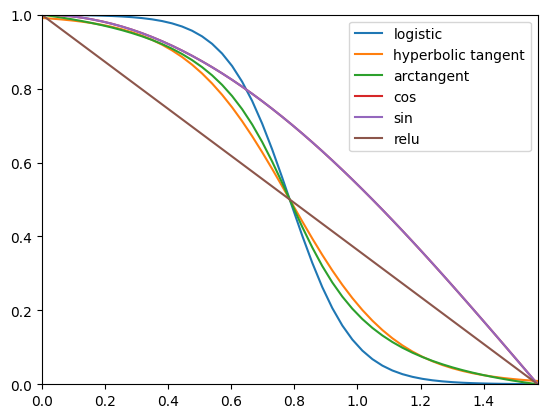

In [6]:
def logistic(x):
    k1 = -10
    shift1 = np.pi / 4
    return 1 - (1 / (1 + np.exp(k1 * (x - shift1))))


def hyperbolic_tangent(x):
    k2 = 3
    shift2 = np.pi / 4
    return 0.5 - 0.5 * np.tanh(k2 * (x - shift2))


def arctangent(x):
    k3 = 5
    shift3 = np.pi / 4
    return 0.5 - (0.5 / (np.arctan(k3 * (np.pi / 2 - shift3)))) * np.arctan(
        k3 * (x - shift3)
    )


def sine(x):
    return np.sin(x + (np.pi / 2.0))


def relu(x):
    return (-2.0 / np.pi) * x + 1.0


plt.plot(
    np.linspace(0, np.pi, 100),
    [logistic(x) for x in np.linspace(0, np.pi, 100)],
    label="logistic",
)
plt.plot(
    np.linspace(0, np.pi, 100),
    [hyperbolic_tangent(x) for x in np.linspace(0, np.pi, 100)],
    label="hyperbolic tangent",
)
plt.plot(
    np.linspace(0, np.pi, 100),
    [arctangent(x) for x in np.linspace(0, np.pi, 100)],
    label="arctangent",
)
plt.plot(
    np.linspace(0, np.pi, 100),
    [np.cos(x) for x in np.linspace(0, np.pi, 100)],
    label="cos",
)
plt.plot(
    np.linspace(0, np.pi, 100),
    [sine(x) for x in np.linspace(0, np.pi, 100)],
    label="sin",
)
plt.plot(
    np.linspace(0, np.pi, 100),
    [relu(x) for x in np.linspace(0, np.pi, 100)],
    label="relu",
)
plt.xlim(0, np.pi / 2)
plt.ylim(0, 1)
plt.legend()
plt.show()

In [7]:
from scipy.integrate import quad
import matplotlib.patches as patches
import matplotlib.pyplot as plt


def get_result_ver_adaptive_func(
    file_name,
    func,
    a,
    plane=Plane(
        np.array([0.99887537, 0.0465492, 0.00900962]) * 1000.0,
        -0.8969238154115642 * 1000.0,
    ),
):
    """func에 함수를 넣어서 사이각도 함수를 조정합니다"""

    data = pd.read_csv(file_name)

    rostime = data["Time"].values

    pose_x = data["Pose.x"].values
    pose_y = data["Pose.y"].values
    pose_z = data["Pose.z"].values

    velocity_x = data["Twist.linear.x"].values
    velocity_y = data["Twist.linear.y"].values
    velocity_z = data["Twist.linear.z"].values

    start = np.array([pose_y[0], pose_z[0]])
    goal = np.array([pose_y[-1], pose_z[-1]]) * 1000.0

    robot_distance = abs(plane.d)

    # 교차점 관련 항목
    intersections = np.empty((0, 3))
    gains = np.empty(0)

    # 차원 관련 항목
    dists = np.empty(0)
    times = np.empty(0)

    # 각도 관련 항목
    thetas = np.empty(0)
    trust_thetas_min = np.empty(0)
    trust_thetas_max = np.empty(0)

    # 역방향 관련 항목
    reverse_dists = np.empty(0)
    last_direction = True

    # 데이터 분석 관련 항목
    errors = np.empty(0)
    dets = np.empty(0)

    for i, e in enumerate(
        zip(pose_x, pose_y, pose_z, velocity_x, velocity_y, velocity_z)
    ):
        p = np.array(e[:3])
        v = np.array(e[3:])

        # 거리와 각도  계산
        dist = plane.distance(p)
        theta = get_theta(v, plane)

        # 교차점과 각도 범위 계산
        forward, intersection = get_intersection_point(p, v, plane)
        trust_theta_min, thrust_theta_max = get_trust_theta(p, plane)

        trust_theta_min -= a
        thrust_theta_max += a

        if trust_theta_min > thrust_theta_max:
            trust_theta_min = (trust_theta_min + thrust_theta_max) / 2.0
            thrust_theta_max = trust_theta_min

        # 각도와 거리에 대한 가중치 계산
        k_theta = get_gain_theta_with_func(
            theta, trust_theta_min, thrust_theta_max, func
        )
        # k_distance = get_gain_distance(dist)
        k_distance = 0.0

        gain = np.clip(k_theta + k_distance, 0.0, float("inf"))

        # If the intersection is nan, skip
        if np.isnan(intersection).any():
            continue

        intersection *= 1000.0  # m -> mm

        # 정방향
        if forward:
            # 역방향이였다가 정방향으로 바뀌었을 때
            if last_direction != forward:
                # if True:
                if len(reverse_dists) > 1:

                    min_reverse_dist = np.min(reverse_dists)
                    max_reverse_dist = np.max(reverse_dists)

                    reverse_distance = np.abs(max_reverse_dist - min_reverse_dist)
                    reverse_dists = np.empty(0)

                    # 역방향 거리가 너무 크면 초기화
                    if reverse_distance > 0.15:
                        print(f"Reset: {reverse_distance}")

                        pass
                        """
                        # 교차점 관련 항목
                        intersections = np.empty((0, 3))
                        gains = np.empty(0)

                        # 차원 관련 항목
                        dists = np.empty(0)
                        times = np.empty(0)

                        # 각도 관련 항목
                        thetas = np.empty(0)
                        trust_thetas_min = np.empty(0)
                        trust_thetas_max = np.empty(0)

                        # 데이터 분석 관련 항목
                        errors = np.empty(0)
                        dets = np.empty(0)
                        """

            try:
                mean, cov = get_weight_mean_and_covariance(intersections, gains)

                mean = mean[1:]
                cov = cov[1:, 1:]

                err = np.abs(np.linalg.norm(mean - goal))
                det = np.linalg.det(cov)

            except Exception as e:
                err = 0.0
                det = 0.0

            # Update

            # 교차점 관련 항목
            intersections = np.vstack([intersections, intersection])
            gains = np.append(gains, gain)

            # 차원 관련 항목
            dists = np.append(dists, dist)
            times = np.append(times, rostime[i] - rostime[0])

            # 각도 관련 항목
            thetas = np.append(thetas, theta)
            trust_thetas_min = np.append(trust_thetas_min, trust_theta_min)
            trust_thetas_max = np.append(trust_thetas_max, thrust_theta_max)

            # 데이터 분석 관련 항목
            errors = np.append(errors, err)
            dets = np.append(dets, det)

        # 역방향
        else:
            # 역방향 거리 계산
            reverse_dists = np.append(reverse_dists, dist)

        last_direction = forward

    try:
        # gains = np.ones_like(gains)
        mean, cov = get_weight_mean_and_covariance(intersections, gains)
    except Exception as e:
        print(e)
        mean = np.array([0, 0, 0])
        cov = np.array([[0, 0, 0], [0, 0, 0], [0, 0, 0]])

    mean = mean[1:]
    cov = cov[1:, 1:]
    err = np.abs(np.linalg.norm(mean - goal))
    det = np.linalg.det(cov)

    return mean, cov, err, det, intersections, gains, times, dists

In [8]:
def log_func_and_a(f, a, func_name, err, det):
    f.write(f"{func_name},{a},{err},{det}\n")

,func_name,a,err_mean,det_mean
0,logistic,-0.174533,86.601871,1.159120e+08
1,logistic,-0.156161,86.617411,1.160322e+08
2,logistic,-0.137789,86.632839,1.161346e+08
3,logistic,-0.119417,86.658309,1.162171e+08
4,logistic,-0.101045,86.549355,1.169477e+08
...,...,...,...,...
95,cos,0.101045,89.153824,3.411413e+08
96,cos,0.119417,90.272361,3.783674e+08
97,cos,0.137789,91.701468,4.269866e+08
98,cos,0.156161,93.517012,4.911706e+08


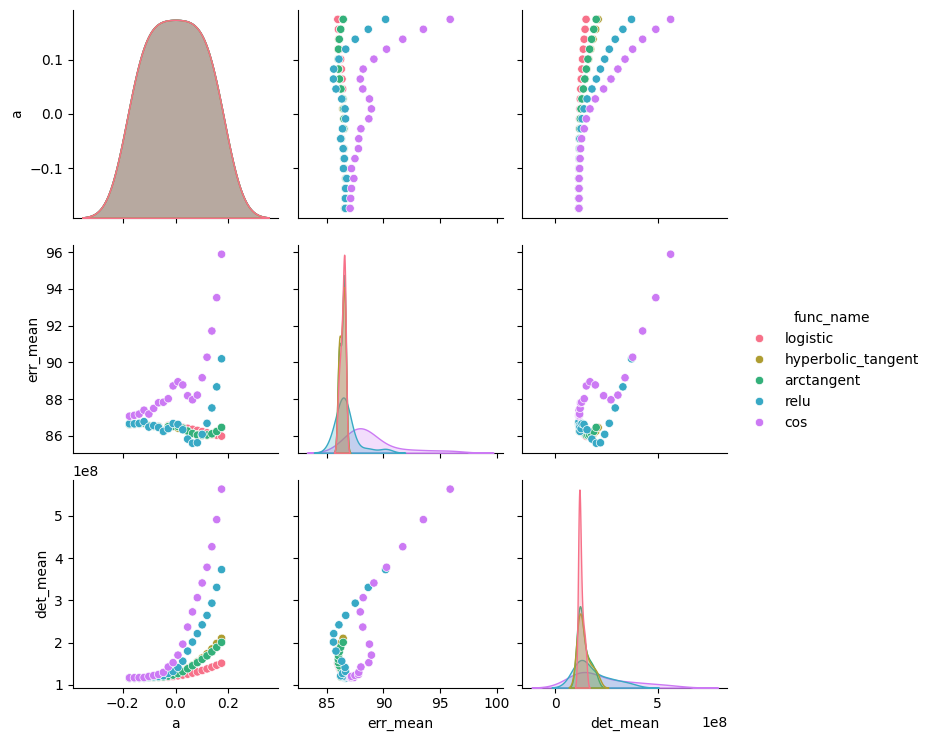

In [9]:
import seaborn as sns
from IPython.display import display, Image

root_dir = "/home/min/7cmdehdrb/project_hj/src/data_analysis/1219_log/function_and_a(1)"

files = sorted(os.listdir(root_dir))

# Get Header
origin_data = pd.read_csv(root_dir + "/" + files[0])[["func_name", "a"]]
origin_data["func_name"] = origin_data["func_name"].astype(str)

for i, file in enumerate(files):
    data = pd.read_csv(root_dir + "/" + file)[["err"]]
    data.columns = [f"err{i}"]

    origin_data = pd.concat([origin_data, data], axis=1)


for i, file in enumerate(files):
    data = pd.read_csv(root_dir + "/" + file)[["det"]]
    data.columns = [f"det{i}"]

    origin_data = pd.concat([origin_data, data], axis=1)

origin_data["err_mean"] = origin_data[[f"err{i}" for i in range(0, 11)]].mean(axis=1)
origin_data["det_mean"] = origin_data[[f"det{i}" for i in range(0, 11)]].mean(axis=1)

final_data = origin_data[["func_name", "a", "err_mean", "det_mean"]]

display(final_data)

sns.pairplot(final_data, hue="func_name", palette="husl")

,func_name,a,err,det
0,arctangent,-0.174533,36.216202,5.102082e+07
1,arctangent,-0.174533,36.647346,7.901830e+07
2,arctangent,-0.174533,40.366519,6.431496e+07
3,arctangent,-0.174533,41.888445,1.870298e+08
4,arctangent,-0.174533,51.900559,2.015492e+07
...,...,...,...,...
1095,relu,0.174533,80.910517,5.593761e+07
1096,relu,0.174533,102.903671,1.485280e+07
1097,relu,0.174533,113.724299,4.295786e+07
1098,relu,0.174533,119.069423,1.299486e+07


,a,err,det
count,1.100000e+03,1100.000000,1.100000e+03
mean,-4.844610e-18,86.954894,1.634620e+08
std,1.059857e-01,52.460718,2.813674e+08
min,-1.745329e-01,31.897316,7.661200e+06
25%,-8.726646e-02,42.734558,3.157491e+07
50%,0.000000e+00,77.263878,6.431496e+07
75%,8.726646e-02,114.330791,1.627435e+08
max,1.745329e-01,232.579405,2.047097e+09


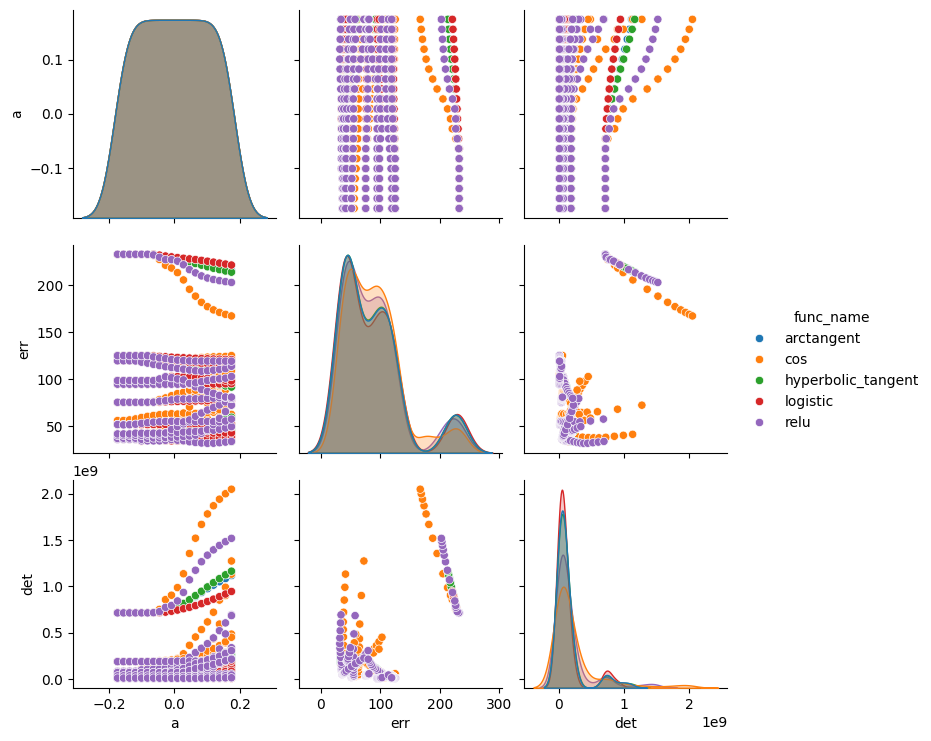

In [17]:
import seaborn as sns
from IPython.display import display, Image

root_dir = "/home/min/7cmdehdrb/project_hj/src/data_analysis/1219_log/function_and_a(1)"

files = sorted(os.listdir(root_dir))

# Get Header
origin_data = pd.read_csv(root_dir + "/" + files[0])
origin_data["func_name"] = origin_data["func_name"].astype(str)

for file in files[1:]:
    data = pd.read_csv(root_dir + "/" + file)
    data["func_name"] = data["func_name"].astype(str)

    origin_data = pd.merge(origin_data, data, how="outer")


display(origin_data)
display(origin_data.describe())

sns.pairplot(origin_data, hue="func_name")

File: 1111_01_0.8945_0.4434_0.2342.csv
Logistic: 92.33782141759413, 48535314.49905303
###Hyperbolic Tangent: 76.9916122323568, 39705048.72617979
Arctangent: 93.33059511602704, 87651753.32051617


File: 1111_02_0.8945_0.4434_0.2342.csv
###Logistic: 88.04978533772122, 10531658.249015618
Hyperbolic Tangent: 116.24753303676736, 31994593.774638332
Arctangent: 138.56286596539613, 44985745.039243855


File: 1111_03_0.8945_0.4434_0.2342.csv
Logistic: 94.68166999475896, 7661200.379181191
Hyperbolic Tangent: 94.68166999475896, 7661200.379181191
Arctangent: 94.68166999475896, 7661200.379181191


File: 1111_04_0.8945_0.4434_0.2342.csv
###Logistic: 83.31044687633548, 88105407.97250976
Hyperbolic Tangent: 102.26089478836735, 68106544.44416381
Arctangent: 95.0581007137182, 76583113.86151055


File: 1111_05_0.8945_0.4434_0.2342.csv
Logistic: 62.05766741386338, 151625390.55697772
###Hyperbolic Tangent: 42.793662587145796, 189072705.3077643
Arctangent: 53.78947320483035, 296565834.01387435


File: 1111_06_0.8945_0.4434_0.2342.csv
###Logistic: 111.49867101649318, 4891668.728659221
Hyperbolic Tangent: 122.23847156021388, 8998897.598617664
Arctangent: 132.33076904738664, 13140433.709576156


File: 1111_11_0.8945_0.4434_0.2342.csv
###Logistic: 43.796455264781514, 87793798.63366115
Hyperbolic Tangent: 37.49174966054329, 56942276.68496226
Arctangent: 45.580411059160895, 82192995.69516814


File: 1111_12_0.8945_0.4434_0.2342.csv
Logistic: 87.52929320442335, 266405743.44320965
###Hyperbolic Tangent: 42.92762030113413, 73643728.36516728
Arctangent: 65.01850969142313, 144679584.5441475


File: 1111_13_0.8945_0.4434_0.2342.csv
Logistic: 59.51510478435507, 483084130.7629613
###Hyperbolic Tangent: 52.83329910861052, 26940563.045900878
Arctangent: 72.79028510684198, 101247472.31893924


File: 1111_14_0.8945_0.4434_0.2342.csv
###Logistic: 201.852845636751, 1378393794.2225113
Hyperbolic Tangent: 227.80204863641876, 767713069.1211392
Arctangent: 193.25483496066346, 1107552876.0600977


File: 1111_15_0.8945_0.4434_0.2342.csv
###Logistic: 29.336024489252377, 998907141.8676947
Hyperbolic Tangent: 34.54993269654726, 112819441.74430794
Arctangent: 46.53200385039206, 282544879.452267



File: 241121_00.csv, Error: 68.59807809884792
File: 241121_01.csv, Error: 113.1358764702254
File: 241121_02.csv, Error: 32.625929369188306
File: 241121_03.csv, Error: 89.41694587714875
File: 241121_04.csv, Error: 91.31209794465097
File: 241121_05.csv, Error: 44.621747706078715
File: 241121_06.csv, Error: 28.150101580178344
File: 241121_08.csv, Error: 12.311869291214604
File: 241121_09.csv, Error: 93.68955721628264

### Error With Gain

* File: 241121_00.csv, Error: 68.59807809884792
* File: 241121_01.csv, Error: 113.1358764702254
* File: 241121_02.csv, Error: 32.625929369188306
* File: 241121_03.csv, Error: 89.41694587714875
* File: 241121_04.csv, Error: 91.31209794465097
* File: 241121_05.csv, Error: 44.621747706078715
* File: 241121_06.csv, Error: 28.150101580178344
* File: 241121_08.csv, Error: 12.311869291214604
* File: 241121_09.csv, Error: 93.68955721628264

### Error Without Gain

* File: 241121_00.csv, Error: 54.823759810236446
* File: 241121_01.csv, Error: 94.283218528968
* File: 241121_02.csv, Error: 316.6142181958776
* File: 241121_03.csv, Error: 317.0227617800522
* File: 241121_04.csv, Error: 144.17938284037675
* File: 241121_05.csv, Error: 17.921195087785875
* File: 241121_06.csv, Error: 308.4539542105772
* File: 241121_08.csv, Error: 14.638400907625803
* File: 241121_09.csv, Error: 57.11341078383454

### Error With Gain (Stable Data)

* File: 1111_01_0.8945_0.4434_0.2342.csv, Error: 86.93067827079996
* File: 1111_02_0.8945_0.4434_0.2342.csv, Error: 107.62842833357246
* File: 1111_03_0.8945_0.4434_0.2342.csv, Error: 85.25769795870804
* File: 1111_04_0.8945_0.4434_0.2342.csv, Error: 63.304287346926316
* File: 1111_05_0.8945_0.4434_0.2342.csv, Error: 48.21964756068994
* File: 1111_06_0.8945_0.4434_0.2342.csv, Error: 125.98097239252708
* File: 1111_11_0.8945_0.4434_0.2342.csv, Error: 40.140333346562294
* File: 1111_12_0.8945_0.4434_0.2342.csv, Error: 69.63409051041019
* File: 1111_13_0.8945_0.4434_0.2342.csv, Error: 56.458179252810964
* File: 1111_14_0.8945_0.4434_0.2342.csv, Error: 160.79706077326853
* File: 1111_15_0.8945_0.4434_0.2342.csv, Error: 36.50764073498284

### Error Without Gain (Stable Data)

* File: 1111_01_0.8945_0.4434_0.2342.csv, Error: 110.89774760242982
* File: 1111_02_0.8945_0.4434_0.2342.csv, Error: 387.6116511886278
* File: 1111_03_0.8945_0.4434_0.2342.csv, Error: 345.75411886692206
* File: 1111_04_0.8945_0.4434_0.2342.csv, Error: 10.625447335684997
* File: 1111_05_0.8945_0.4434_0.2342.csv, Error: 130.67401108121433
* File: 1111_06_0.8945_0.4434_0.2342.csv, Error: 132.46175905023853
* File: 1111_11_0.8945_0.4434_0.2342.csv, Error: 275.37915327615514
* File: 1111_12_0.8945_0.4434_0.2342.csv, Error: 186.6905450245124
* File: 1111_13_0.8945_0.4434_0.2342.csv, Error: 382.1621495374914
* File: 1111_14_0.8945_0.4434_0.2342.csv, Error: 97.60896152501743
* File: 1111_15_0.8945_0.4434_0.2342.csv, Error: 128.6535134240926

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 주어진 점을 만족하는 계수
a = 4
b = -4.0
c = 1

# 함수 정의
x = np.linspace(0, 1.0, 500)  # x 범위
# y = a * x**2 + b * x + c
y = 5 * (x - np.sqrt(0.2)) ** 2

# 그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(x, y, color="blue")
plt.axhline(0, color="black", linewidth=0.5, linestyle="--")
plt.axvline(0, color="black", linewidth=0.5, linestyle="--")
plt.title("Quadratic Function Passing Through (0, 1) and (0.5, 0)")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, 1.0)
plt.ylim(-0.1, 1)
plt.legend()
plt.grid()
plt.show()